# Embeddings Demonstration - Product Attribute Extraction

This notebook demonstrates how to use embeddings and retrieval augemented generation (RAG) approach to fill-in attributes for products at scale when similar products exists in the catalogue.




<table align="left"  width="100%">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/guruvittal/codesamples/blob/main/Embeddings_Demo.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/guruvittal/codesamples/blob/main/Embeddings_Demo.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/guruvittal/codesamples/main/Embeddings_Demo.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

# Setup

### Install Dependencies (If Needed)

The list `packages` contains tuples of package import names and install names. If the import name is not found then the install name is used to install quitely for the current user.

In [86]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.bigquery', 'google-cloud-bigquery[pandas]'),
    ('opendatasets','opendatasets'),
    ('jsonpickle','jsonpickle')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U --user



import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [87]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Authenticate

If you are using Colab, you will need to authenticate yourself first. The next cell will check if you are currently using Colab, and will start the authentication process.

If you are using Vertex AI Workbench, you will not require additional authentication.

In [88]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

## Reference parameters & Constants

In [89]:
# GCP
PROJECT = "argolis-project-340214"   # @param {type: "string"}
LOCATION = 'us-central1' # @param {type: "string"}

# BigQuery
PRODUCT_TABLE = 'argolis-project-340214.PIMDemo.KaggleData' # @param {type: "string"}


## Helper files



### Embeddings - Request & Response Methods

Generating embeddings from the multimodal model requires a few function calls to be enabled.

In [90]:
import base64
from google.cloud import aiplatform
from google.protobuf import struct_pb2
from functools import cache
import time
import typing
import logging


class EmbeddingResponse(typing.NamedTuple):
  text_embedding: typing.Sequence[float]
  image_embedding: typing.Sequence[float]


class EmbeddingPredictionClient:
  """Wrapper around Prediction Service Client."""
  def __init__(self, project : str,
    location : str = "us-central1",
    api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com"):
    client_options = {"api_endpoint": api_regional_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    self.client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    self.location = location
    self.project = project

  def get_embedding(self, text : str = None, image_path : str = None):
    """image_path can be a local path or a GCS URI."""
    if not text and not image_path:
      raise ValueError('At least one of text or image_bytes must be specified.')

    instance = struct_pb2.Struct()

    if text:
      if len(text) > 1024:
        logging.warning('Text must be less than 1024 characters. Truncating text.')
        text = text[:1024]
      instance.fields['text'].string_value = text

    if image_path:
      image_struct = instance.fields['image'].struct_value
      if image_path.lower().startswith('gs://'):
        image_struct.fields['gcsUri'].string_value = image_path
      else:
        with open(image_path, "rb") as f:
          image_bytes = f.read()
        encoded_content = base64.b64encode(image_bytes).decode("utf-8")
        image_struct.fields['bytesBase64Encoded'].string_value = encoded_content

    instances = [instance]
    endpoint = (f"projects/{self.project}/locations/{self.location}"
      "/publishers/google/models/multimodalembedding@001")
    try:
      response = self.client.predict(endpoint=endpoint, instances=instances)

      text_embedding = None
      if text:
        text_emb_value = response.predictions[0]['textEmbedding']
        text_embedding = [v for v in text_emb_value]

      image_embedding = None
      if image_path:
        image_emb_value = response.predictions[0]['imageEmbedding']
        image_embedding = [v for v in image_emb_value]

      return EmbeddingResponse(
        text_embedding=text_embedding,
        image_embedding=image_embedding)
    except Exception as e:
      print(e)
      return None

@cache
def get_client(project):
  return EmbeddingPredictionClient(project)


def embed(project,text,image_path=None):
  client = get_client(project)
  start = time.time()
  response = client.get_embedding(text=text, image_path=image_path)
  end = time.time()
  print('Embedding Time: ', end - start)
  return response

### Big Query - Helper Methods

In [91]:
from google.cloud import bigquery

def create_table(client, table_id):
    table = bigquery.Table(table_id)
    table = client.create_table(table,exists_ok=True)  # Make an API request
    print(
        "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
    )
def upload_df_into_bq(client, table_id, df):
    #df.to_gbq(table_id, PROJECT, if_exists='replace', progress_bar=True)
    job_config = bigquery.LoadJobConfig()
    job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
    #job_config.skip_leading_rows = 1
    job_config.autodetect = True
    job_config.source_format=bigquery.SourceFormat.CSV

    try:
      job = client.load_table_from_dataframe(df, table_id, job_config=job_config)
      job.result()
      print(
        "Uploaded dataframe into table {}.{}".format(PROJECT, table_id)
      )
    except Exception as error:
      print("Error:", error)



### Cloud Storage - Helper Methods

In [92]:

from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    #generation_match_precondition = 0
    blob.upload_from_filename(source_file_name)
    print(f"File {source_file_name} uploaded to {destination_blob_name}.")

def download_blob(bucketname):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucketname)

    # List all objects that satisfy the filter.
    blobs=bucket.list_blobs()

    if os.path.isdir(bucketname):
      print("Directory exists:", bucketname)
    else:
      os.mkdir(bucketname)
      print("Directory '% s' created" % bucketname)
    i = 0
    for blob in blobs:
      i=i+1
      destination_uri = f"{bucketname}/{blob.name}"
      blob.download_to_filename(destination_uri)
    print(f"Blobs downloaded: {i}")



###Gemini - Pro - Vision: Helper Methods

In [93]:
import base64
import vertexai
import urllib
import ast
import textwrap
import nltk
nltk.download('punkt')

def count_tokens(text):
  tokens = nltk.word_tokenize(text)
  return len(tokens)

from vertexai.preview.generative_models import GenerativeModel, Image

import matplotlib.pyplot as plt
import numpy as np

vertexai.init(project=PROJECT, location=LOCATION)

prompt="Provide a simple description and explanation of this image"

generation_config={
    "max_output_tokens": 2048,
    "temperature": 0,
    "top_p": 1,
    "top_k": 1
}

model = GenerativeModel("gemini-pro-vision")

def GeminiResponse(image):
  try:
    with open(image,"rb") as image_file:
      image_bytes = image_file.read()
    objectImage = Image.from_bytes(image_bytes)
    responses = model.generate_content(
        [prompt,objectImage],
        generation_config=generation_config,
        stream=True
    )
    resp = []
    for response in responses:
      resp.append(response)
    try:
      gem = resp[0].candidates[0].content.parts[0].text
    except Exception as e:
      gem = "Withheld response from Gemini"
      print("Error:", e)
  except Exception as e:
    gem = "No response from Gemini"
    print("Error:", e)
  print("Token size:", count_tokens(gem), "Length:", len(gem))
  return gem



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Ingest Reference Dataset

We will be using a public dataset on Kaggle for this demonstration. After downloading the data, save the file locally or on a cloud storage bucket for any future reference.

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/PromptCloudHQ/flipkart-products/download")
!gsutil cp /content/flipkart-products/flipkart_com-ecommerce_sample.csv gs://pimdata/

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mitguru
Your Kaggle Key: ··········


100%|██████████| 5.50M/5.50M [00:00<00:00, 38.4MB/s]

Copying file:///content/flipkart-products/flipkart_com-ecommerce_sample.csv [Content-Type=text/csv]...
\ [1 files][ 36.4 MiB/ 36.4 MiB]                                                
Operation completed over 1 objects/36.4 MiB.                                     


In [94]:
import pandas as pd
!mkdir /content/flipkart-products/
!gsutil cp gs://pimdata/flipkart_com-ecommerce_sample.csv /content/flipkart-products/
full_ds = pd.read_csv('flipkart-products/flipkart_com-ecommerce_sample.csv')


mkdir: cannot create directory ‘/content/flipkart-products/’: File exists
Copying gs://pimdata/flipkart_com-ecommerce_sample.csv...
/ [1 files][ 36.4 MiB/ 36.4 MiB]                                                
Operation completed over 1 objects/36.4 MiB.                                     


# Data Exploration

## Understand the training data columns

In [95]:
full_ds.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [96]:
pd.options.display.max_colwidth = 1000
print(full_ds.loc[13855,["description"]])

description    Numero Uno Solid Men's Round Neck T-Shirt\n                         Price: Rs. 758\n\t\t\t\t\n\t\t\tThis casual shirt was once worn layered with formal clothes has now moved\r\non with a fashion statement of its own. Evoking a sense of effortless casual\r\nstyle this shirt is the perfect pick for your weekend wardrobe. Crafted from \r\ncotton it is cut with full sleeves and a round neck that add to the laid back look \r\nof this design.\r\n\r\nWear yours with a pair of shorts or rugged denims.\r\n\r\nDid you know?\r\nThere are over 2 million t-shirts sold every year!\r\n\r\n\n\nFull sleeves::Round neck::Cotton 1X1 RIB::Hand wash cold::Use mild detergent::Wash inside out::Wash dark colours separately::Do not bleach::Do not soak::Do not wring or squeeze::Medium iron::Do not iron on print\nThis casual shirt was once worn layered with formal clothes has now moved\r\non with a fashion statement of its own. Evoking a sense of effortless casual\r\nstyle this shirt is the perfec

In [97]:
full_ds["description"] = full_ds["description"].str.replace('"', '')
full_ds["description"] = full_ds["description"].str.replace("'", "")
full_ds["description"] = full_ds["description"].str.replace('\n', '')
full_ds["description"] = full_ds["description"].str.replace('\r', '')


## Understand the training data quality

Token size: 31 Length: 162
Gemini Response:  The image shows a model wearing three different colors of the same
style of shorts. The shorts are a stretchy, cotton material that is
perfect for working out or


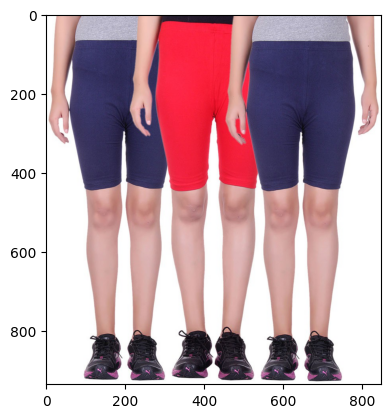

Original Description: Key Features of Alisha Solid Womens Cycling Shorts Cotton Lycra Navy,
Red, Navy,Specifications of Alisha Solid Womens Cycling Shorts Shorts
Details Number of Contents in Sales Package Pack of 3 Fabric Cotton
Lycra Type Cycling Shorts General Details Pattern Solid Ideal For
Womens Fabric Care Gentle Machine Wash in Lukewarm Water, Do Not
Bleach Additional Details Style Code ALTHT_3P_21 In the Box 3 shorts


In [98]:
row = full_ds.iloc[0]
#row = full_ds.iloc[75]
img_path = ast.literal_eval(row["image"])[0]
blobname = row["uniq_id"]+".jpg"
try:
  urllib.request.urlretrieve(img_path,"my_file.jpg")
except Exception as error:
  print("Error:", error, "Error getting image file - skipping record:", img_path)

# Read the image data
image = np.array(plt.imread('/content/my_file.jpg'))

# Display the image
plt.imshow(image)

gems = GeminiResponse("/content/my_file.jpg")

print("Gemini Response:", textwrap.fill(gems))
plt.show()
print("Original Description:", textwrap.fill(row["description"]))

# Data Ingestion

## Ingest data to Big Query

In [ ]:
client = bigquery.Client(PROJECT)

create_table(client, PRODUCT_TABLE)

upload_df_into_bq(client, PRODUCT_TABLE, full_ds)


# Generate Embeddings for Dataset & Store in Big Query

## Update Big Query Schema to store embeddings

In [ ]:
table = client.get_table(PRODUCT_TABLE)
original_schema = table.schema
new_schema = original_schema[:]  # Creates a copy of the schema.
new_schema.append(bigquery.SchemaField('text_embedding', 'FLOAT', mode='REPEATED'))
new_schema.append(bigquery.SchemaField('image_embedding', 'FLOAT', mode='REPEATED'))

table.schema = new_schema
table = client.update_table(table, ["schema"])  # Make an API request.

if len(table.schema) == len(original_schema) + 2 == len(new_schema):
    print("Two new columns have been added.")
else:
    print("Something went wrong.")

Two new columns have been added.


## Load Big Query Table to a Dataframe

In [99]:
## Query against Big Query Table to extract a section of items for building vector space

client = bigquery.Client(PROJECT)

# Only fetch rows with no embedding. Bypass this query to update all rows
query = f"""
SELECT
  uniq_id,
  description,
  image
FROM
  `{PRODUCT_TABLE}`
order by uniq_id asc

"""
query_job = client.query(query)
query_job.result()
destination = query_job.destination
rows = client.list_rows(destination, max_results=100)
print(rows.total_rows, ": Total no. of rows stored in Big Query")

## Store Query Outut to a dataframe

df = rows.to_dataframe()

for index, row in df.iterrows():
  print(index, row['uniq_id'], row['description'])

20000 : Total no. of rows stored in Big Query
0 0001d5429cf08061039da491b1aad68d Key Features of Rastogi Handicrafts JOINT LESS LEAK PROOF DECORATIVE 950 ml Bottle 950 ml,Rastogi Handicrafts JOINT LESS LEAK PROOF DECORATIVE 950 ml Bottle (Pack of 1, BROWN) Price: Rs. 1,099 PURE COPPER GOOD FOR AYURVEDA HEALTH BENEFIT , COMES WITH A BEAUTY FULL DARI CLOTH HAND BAG,Specifications of Rastogi Handicrafts JOINT LESS LEAK PROOF DECORATIVE 950 ml Bottle (Pack of 1, BROWN) General Body Material COPPER Type Bottle In the Box Number of Contents in Sales Package Pack of 1 Sales Package 1 bottle 1 cloth bag
1 0005bab836087ed542c5e23111078035 Buy Tiedribbons Gift For World Greatest Grand Father A5 Planner/Organizer Hard Bound for Rs.699 online. Tiedribbons Gift For World Greatest Grand Father A5 Planner/Organizer Hard Bound at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.
2 0005bbbd05785765697e048f56b9b17e Buy Pet Club51 PC231 L Pet Bed for 

## Generate Embeddings & Store in Big Query + Download Images & Store in Cloud Storage

In [18]:
import urllib
import os
import ast


#Set to 1 to clean up stragglers if rows not a multiple of batch_size
BATCH_SIZE = 10

text_embeddings, image_embeddings, ids = [], [], []


for index, row in df.iterrows():
  ImageList = ast.literal_eval(row["image"])
  print(f'\n{index+1}: {row["description"]}\nimage_uri:{ImageList[0]}')
  blobname = row["uniq_id"]+".jpg"
  try:
    urllib.request.urlretrieve(ImageList[0], "my_file.jpg")
  except Exception as error:
    print("Index:" , index, "Error getting image file - skipping record:", ImageList[0])
    continue
  upload_blob("pimproductimages","my_file.jpg",blobname)

  #Augment product description with Gemini response for each image
  gem = GeminiResponse('/content/my_file.jpg')
  if len(gem)>100:
    gem = gem[:100]

  augmentedDescription = gem + row["description"]

  try:
    res = embed(PROJECT,augmentedDescription,"/content/my_file.jpg")
    print(res.text_embedding[:5])
    print(res.image_embedding[:5])
  except Exception as error:
    print("Index:" , index, "Error provided image is not valid:", ImageList[0])
    continue

  text_embeddings.append(res.text_embedding)
  image_embeddings.append(res.image_embedding)
  ids.append(row["uniq_id"])
  if len(text_embeddings) == BATCH_SIZE:
    print(f'\nBATCHING {BATCH_SIZE} UPDATES TO BQ...')
    query = f"""
        UPDATE
          `{PRODUCT_TABLE}`
        SET
          text_embedding = (
            CASE
              {''.join([f'WHEN uniq_id = "{ids[i]}" THEN {text_embeddings[i]}{chr(10)}' for i in range(len(ids))])}
            END),
          image_embedding = (
            CASE
              {''.join([f'WHEN uniq_id = "{ids[i]}" THEN {image_embeddings[i]}{chr(10)}' for i in range(len(ids))])}
            END)
        WHERE
          uniq_id IN {str(ids).replace('[','(').replace(']',')')}
    """
    start = time.time()
    query_job = client.query(query)
    query_job.result()  # Wait for the query to complete.
    end = time.time()
    print('BQ Update Time: ', end - start)
    #text_embeddings, image_embeddings, ids = [], [], []



1: Key Features of Rastogi Handicrafts JOINT LESS LEAK PROOF DECORATIVE 950 ml Bottle 950 ml,Rastogi Handicrafts JOINT LESS LEAK PROOF DECORATIVE 950 ml Bottle (Pack of 1, BROWN) Price: Rs. 1,099 PURE COPPER GOOD FOR AYURVEDA HEALTH BENEFIT , COMES WITH A BEAUTY FULL DARI CLOTH HAND BAG,Specifications of Rastogi Handicrafts JOINT LESS LEAK PROOF DECORATIVE 950 ml Bottle (Pack of 1, BROWN) General Body Material COPPER Type Bottle In the Box Number of Contents in Sales Package Pack of 1 Sales Package 1 bottle 1 cloth bag
image_uri:http://img6a.flixcart.com/image/bottle/p/h/h/jl-btl-d-bag-plain-rastogi-handicrafts-950-joint-less-leak-proof-original-imaegsg3enxub8dg.jpeg
File my_file.jpg uploaded to 0001d5429cf08061039da491b1aad68d.jpg.
Token size: 31 Length: 145
Embedding Time:  2.189974308013916
[0.0480396897, -0.046916686, 0.0192804094, 0.0184625164, 0.0158095211]
[-0.00703410245, 0.00818781927, 0.0145073766, 0.0144627178, 0.00154283235]

2: Buy Tiedribbons Gift For World Greatest Gran

Token size: 30 Length: 154
Embedding Time:  0.9625544548034668
[0.0149439415, -0.0273264963, -0.00471361168, -0.0211363547, 0.0245992783]
[-0.00657146377, 0.0241020713, -0.00521199545, 0.0112465099, 0.0147540402]

30: DailyObjects Back Cover for Apple iPad 2/3/4 (White)                         Price: Rs. 1,685							About DailyObjects:This slim back cover is a product of DailyObjects.com, India’s largest seller of designer and customisable smartphone cases. DailyObjects has a curated collection of exclusive licensed art that we have painstakingly sourced from artists that we love, from around the world. We currently have over 3000 amazing designs from over 50 artists from 25 countries across the world, available for more than 50 different models of smartphones.About DailyObjects:This slim back cover is a product of DailyObjects.com, India’s largest seller of designer and customisable smartphone cases. DailyObjects has a curated collection of exclusive licensed art that we have painstak

Token size: 29 Length: 142
400 Image embedding failed with the following error: Text field must be smaller than 1024 characters.
Embedding Time:  1.2466621398925781
Index: 29 Error provided image is not valid: http://img6a.flixcart.com/image/cases-covers/back-cover/z/h/u/dailyobjects-dailyobjects-griffin-case-for-ipad-2-3-4-1100x1100-imae9chfhcbghbgy.jpeg

31: Speedwav Plastic Car Door Guard (White, Pack of 4, Toyota, Innova)                         Price: Rs. 600							Car Bumper Safety Guard ProtectorsFeatures :Can be installed in front and rear of the car bumper.Easy installation, just pull the double tape upper sticker and fix on any place of your car, can be used as Car -  Body Shield, Car door guardThese soft guard will protect your car from scratches while parking.Protect bumper corner, avoid impacts & scratches on the car.Universal fitments for all vehicles.Size: 150x535x25mmPackage Contents:4 X Car Bumper Safety Guard Protectors>Car Bumper Safety Guard ProtectorsFeatures :Can 

Token size: 24 Length: 125
Embedding Time:  0.7885401248931885
[0.0208687466, -0.0468606874, 0.0124738924, -0.036795266, -0.0179023333]
[-0.00832867902, 0.0116782449, -0.019407833, 0.00496111345, -0.00935422163]

32: Cocoon Stylish Square Toe Loafers - Buy Cocoon Stylish Square Toe Loafers - 1058..F only for Rs. 548 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
image_uri:http://img5a.flixcart.com/image/shoe/8/a/h/black-1058-f-cocoon-38-original-imadv4gcyvrc7vdz.jpeg
File my_file.jpg uploaded to 0086f7293aee8823ec72ee21fc33300e.jpg.
Token size: 31 Length: 140
Embedding Time:  0.9988424777984619
[0.00689980946, -0.0415607914, 0.00502622221, 0.016370466, -0.012305609]
[-0.0120467972, 0.00892780721, 0.00927943643, -0.0180262625, 0.00262044347]

33: Specifications of Rs Electrical RS-8500 Top Filter 3 in 1 More Function Power Aquarium Filter (Mechanical Filtration for Salt Water and Fresh Water) In the Box Pack of 1 Sales Package RS

Token size: 30 Length: 132
Embedding Time:  2.198213577270508
[0.0130354166, -0.0297342706, -0.00242133858, -0.0252223387, 0.0048112371]
[-0.0215684827, 0.0525705, -0.0456084386, -0.0077016186, -0.0188694168]

45: Fashionera Metal Choker - Buy Fashionera Metal Choker only for Rs. 245 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
image_uri:http://img5a.flixcart.com/image/necklace-chain/3/6/a/fas-rjn41-fashionera-choker-1100x1100-imaeczjfvsuejhty.jpeg
File my_file.jpg uploaded to 00a6a13741e3f6c50db714cf669067b2.jpg.
Token size: 27 Length: 132
Embedding Time:  0.8495781421661377
[0.00636099419, 0.0116798179, 0.0266797785, -0.0257876925, -0.0134656951]
[-0.0104734227, 0.0603988618, 0.0104091689, -0.00463605672, -0.0247166343]

46: Falconoverseas Splendid Beauty Brass Necklace - Buy Falconoverseas Splendid Beauty Brass Necklace only for Rs. 247 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. C

Token size: 31 Length: 158
Embedding Time:  1.5852506160736084
[0.0428048111, -0.0573833846, -0.00825434178, 0.0327469595, 0.00230698683]
[0.00421521766, 0.0412377454, 0.00679598469, -0.0203717165, -0.00738076959]

53: Karatcraft Corona Yellow Gold Diamond 18 K Ring - Buy Karatcraft Corona Yellow Gold Diamond 18 K Ring only for Rs. 28966 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
image_uri:http://img5a.flixcart.com/image/ring/t/d/z/rda0017-16-jk-16-karatcraft-ring-original-imae7gsd5ahe2mwg.jpeg
File my_file.jpg uploaded to 00b35cdacb0bf4230cb8372774bc0e8c.jpg.
Token size: 28 Length: 125
Embedding Time:  1.0020403861999512
[0.0478022471, 0.00215275516, 0.0210645162, -0.00185383554, 0.0315946825]
[0.0208444707, 0.0288224556, 0.00480496511, 0.00366287678, -0.00295335]

54: DailyObjects Back Cover for Apple iPad Mini/Retina Display (White)                         Price: Rs. 1,685							About DailyObjects:This slim back cover is 

Token size: 13 Length: 66
400 Image embedding failed with the following error: Text field must be smaller than 1024 characters.
Embedding Time:  1.3025627136230469
Index: 53 Error provided image is not valid: http://img5a.flixcart.com/image/cases-covers/back-cover/d/9/y/dailyobjects-dailyobjects-plenty-of-fish-in-the-sea-blue-case-1100x1100-imae9ch8gyqwhgnc.jpeg

55: Jewelizer Alloy Necklace                         Price: Rs. 299							All you need to make even the plainest dress downright fabulous. You can thank us later.All you need to make even the plainest dress downright fabulous. You can thank us later.
image_uri:http://img6a.flixcart.com/image/necklace-chain/z/k/u/nfjs1n0024-go4shopping-necklace-1100x1100-imae4hchzgymawhs.jpeg
File my_file.jpg uploaded to 00bf204f591bea9ef88730ded8a155e5.jpg.
Token size: 18 Length: 81
Embedding Time:  0.8239572048187256
[0.00112880161, -0.0213328805, 0.010705593, 0.00559253804, -0.00536195422]
[-0.00229064678, 0.0294716172, -0.0234532263, 0.0143

Token size: 27 Length: 119
Embedding Time:  1.0399832725524902
[0.0322428942, -0.0622163303, 0.00638498506, 0.0271759201, 0.0226150043]
[-0.0186027624, 0.0560860448, 0.00463519851, 0.0194620211, -0.00230695796]

67: Key Features of YGS Keyboard Case for Asus Memo Pad 7in Tab Portfolio Folio Case with Magnetic lock for safety Four corner elastic straps to keep the device securely tucked inside With Stand to easily watch movies and do a video chat Made of high grade synthetic leather with durable stitching NOTE-This is a universal case for all 7Inch Android Tablets so it features NO CAMERA CUTS moreover please check compatibity with your Tablet as it works through Micro USB  only.,YGS Keyboard Case for Asus Memo Pad 7in Tab (Pink) Price: Rs. 499 YGS Universal QWERTY keyboard for Android Tablet provides you the dual benefit of protecting your Tab as well as providing you with a full functioning keyboard. Intricate stitching makes the case long lasting and durable. The display stand makes 

Token size: 31 Length: 154
Embedding Time:  1.4174563884735107
[0.031676013, -0.00612274418, -0.00165112829, -0.024862146, 0.0142520312]
[-0.0134004047, 0.0323779173, -0.0113070859, 0.0368508175, -0.00256579532]

68: ARRA Solid Wood 4 Seater Sofa (Finish Color - Black)                         Price: Rs. 25,800							ARRA offers Empire Sofa Set 2+1+1 Black. Style Elegance is what this sofa cum bed will bestow. Impress your guests with this designer sofa cum bed. Assure comfort and quality by buying this sofa cum bed.ARRA offers Empire Sofa Set 2+1+1 Black. Style Elegance is what this sofa cum bed will bestow. Impress your guests with this designer sofa cum bed. Assure comfort and quality by buying this sofa cum bed.
image_uri:http://img6a.flixcart.com/image/sofa-sectional/n/e/d/arra0200-cherry-hardwood-arra-black-black-1100x1100-imaebsfyfjtzycu9.jpeg
File my_file.jpg uploaded to 00ec9f75889b739b7bc4532e1b477014.jpg.
Token size: 29 Length: 140
Embedding Time:  0.7838137149810791
[-0.0116

Token size: 30 Length: 136
Embedding Time:  1.1057255268096924
[0.0428843424, 0.0196967553, 0.028866725, 0.0312013235, -0.0103485538]
[0.0245746579, 0.0480906852, 0.0067843115, 0.013041243, -0.0184283443]

77: The Fine World Exclusive Pattern For Baby Girls Brass Zircon Metal Drop Earring - Buy The Fine World Exclusive Pattern For Baby Girls Brass Zircon Metal Drop Earring only for Rs. 629 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
image_uri:http://img6a.flixcart.com/image/earring/5/k/8/e38rj010138gr-1-the-fine-world-drop-earring-1100x1100-imae5p5qzpg5chgm.jpeg
File my_file.jpg uploaded to 0100beb24bfc0cc4ab13177e63088c06.jpg.
Token size: 30 Length: 136
Embedding Time:  0.9312140941619873
[-0.00619578175, 0.00155043975, 0.0466865748, 0.0323146395, 0.00649603736]
[-0.0254207794, 0.050527487, 0.0262379032, 0.0599499196, -0.013569504]

78: Regent Analog 31 cm Dia Wall Clock (Black, With Glass)                         Price: Rs.

Token size: 31 Length: 130
400 Image embedding failed with the following error: Text field must be smaller than 1024 characters.
Embedding Time:  0.49518418312072754
Index: 91 Error provided image is not valid: http://img5a.flixcart.com/image/hair-dryer/6/u/r/hnk-2300w-professional-hair-dryer-sp1622w-1100x1100-imaefrm9r6ydgjfp.jpeg

93: Key Features of BFT 6 W LED Cool White Bulb Pack of 4 Bulb,BFT 6 W LED Cool White Bulb (White, Pack of 4) Price: Rs. 1,000 Introducing new technology in led lighting LED filament. Best suited for chandeliers table lamps and light fixtures in general as it spreads light 360-degrees,Specifications of BFT 6 W LED Cool White Bulb (White, Pack of 4) General Brand BFT Model Number BFTCW6P4 Model Name Cool White Body and Design Features Material Glass Bulb Base B22 Lighting Features Bulb Type LED Light Color White Lumen 700 Power Features Power Consumption 6 W In the Box Sales Package 4 Bulb Pack of 4 Additional Features Suitable for chandeliers, table lamp, l

Token size: 31 Length: 143
Embedding Time:  0.8862712383270264
[0.0593063757, -0.0147979753, -0.016284436, 0.0176489353, 0.0363787636]
[0.00334949233, 0.0598812029, -0.00777288247, 0.00466322759, 0.0119824428]

95: Wave Walk Simple and Elegant Slip On Shoes - Buy Wave Walk Simple and Elegant Slip On Shoes - J-7 only for Rs. 599 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
image_uri:http://img5a.flixcart.com/image/shoe/w/e/d/brown-j-7-wave-walk-6-original-imaeye33yyghwhfs.jpeg
File my_file.jpg uploaded to 0141a1c365876f10870653e3b4426465.jpg.
Token size: 30 Length: 123
Embedding Time:  4.569458723068237
[0.0319175906, -0.00760504324, 0.037559323, -0.0317213908, 0.00282544084]
[-0.00707687624, 0.0509625152, -0.00352418958, 0.00279201753, 0.00543497922]

96: Flipkart.com: Buy Liza Women Heels only for Rs. 1113 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
image_uri:http:/

## Download Images from Cloud Storage to Local


In [59]:
from google.cloud import storage

import os

#Download images from bucket 'pimproductimages' to local folder: 'pimproductimages'

download_blob("pimproductimages")

Directory exists: pimproductimages
Blobs downloaded: 94


# Publish Embeddings in a JSON format on Cloud Storage

### Store embeddings in a JSON file

In [100]:
from tqdm import tqdm
import json
import tempfile

# Create temporary file to write embeddings to
embeddings_file = tempfile.NamedTemporaryFile(suffix=".json", delete=False)

BATCH_SIZE = 1000
print(len(ids))
with open(embeddings_file.name, "a") as f:
    for i in tqdm(range(0, len(ids), BATCH_SIZE)):
      print("Record:", i)
      # Append to file
      embeddings_formatted = [
            json.dumps(
                {
                    "id": str(id)+"_T",
                    "embedding": [str(value) for value in embedding],
                }
            )
            + "\n"
            for id, embedding in zip(ids, text_embeddings)
            if embedding is not None
      ]
      f.writelines(embeddings_formatted)

with open(embeddings_file.name, "a") as f:
    for i in tqdm(range(0, len(ids), BATCH_SIZE)):
      print("Record:", i)
      # Append to file
      embeddings_formatted = [
            json.dumps(
                {
                    "id": str(id)+"_I",
                    "embedding": [str(value) for value in embedding],
                }
            )
            + "\n"
            for id, embedding in zip(ids, image_embeddings)
            if embedding is not None
      ]
      f.writelines(embeddings_formatted)

91


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Record: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Record: 0


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


## Move JSON file to Cloud Storage bucket

In [101]:

# Bucket name for storing embeddings
EMBEDDINGS_URI = "gs://pimembeddings/"

print(f"Length - Image Embeddings:{len(image_embeddings)}, Text Embeddings:{len(text_embeddings)}, Ids:{len(ids)}")
!echo `gsutil ls gs://pimproductimages | wc -l` images
!wc -l {embeddings_file.name}

!gcloud config set project $PROJECT
print (PROJECT)

!gsutil ls gs://pimembeddings/
!gsutil rm  gs://pimembeddings/*

! gsutil cp {embeddings_file.name} {EMBEDDINGS_URI}

Length - Image Embeddings:91, Text Embeddings:91, Ids:91
94 images
182 /tmp/tmpws4vyzw5.json
Updated property [core/project].
argolis-project-340214
gs://pimembeddings/tmpkwbl_e3x.json
Removing gs://pimembeddings/tmpkwbl_e3x.json...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file:///tmp/tmpws4vyzw5.json [Content-Type=application/json]...
|
Operation completed over 1 objects/4.1 MiB.                                      


# Vector Store using Matching Engine




## Create Matching Engine Index

In [102]:
# Initiate Vertex AI project
from google.cloud import aiplatform
import vertexai
vertexai.init(project=PROJECT, location="us-central1")

# Bucket name for storing embeddings
EMBEDDINGS_URI = "gs://pimembeddings/"

# Create Index with Tree AH algorithm with Cosine distance for proximity measure

tree_ah_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name='PIM_multimodal_batch_tree_cosine',
    contents_delta_uri=EMBEDDINGS_URI,
    dimensions=1408,
    approximate_neighbors_count=150,
    distance_measure_type="COSINE_DISTANCE",
    leaf_node_embedding_count=500,
    leaf_nodes_to_search_percent=7,
    description='Based on ~91 product listings for which we have both a description and image',
)

INDEX_RESOURCE_NAME = tree_ah_index.resource_name

print(INDEX_RESOURCE_NAME)

INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:Creating MatchingEngineIndex
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:Create MatchingEngineIndex backing LRO: projects/742458474659/locations/us-central1/indexes/6883369400389337088/operations/6338178690060386304
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:MatchingEngineIndex created. Resource name: projects/742458474659/locations/us-central1/indexes/6883369400389337088
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:To use this MatchingEngineIndex in another session:
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:index = aiplatform.MatchingEngineIndex('projects/742458474659/locations/us-central1/indexes/6883369400389337088')


projects/742458474659/locations/us-central1/indexes/6883369400389337088


## Create Index Endpoint

In [ ]:
# Retrieve the project number
PROJECT_NUMBER = !gcloud projects list --filter="PROJECT_ID:'{PROJECT}'" --format='value(PROJECT_NUMBER)'
PROJECT_NUMBER = PROJECT_NUMBER[0]

# Define VPC Network to host endpoint if public endpoint is not enabled
VPC_NETWORK = "matching-engine-vpc-network"
VPC_NETWORK_FULL = "projects/{}/global/networks/{}".format(PROJECT_NUMBER, VPC_NETWORK)
VPC_NETWORK_FULL


# Instantiate End point
DISPLAY_NAME = "PIM_multimodal_batch_tree_cosine"
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=DISPLAY_NAME,
    description=DISPLAY_NAME,
    public_endpoint_enabled=True
#    network=VPC_NETWORK_FULL,
)

## Deploy index to Endpoint

In [78]:
DEPLOYED_INDEX_ID = "PIM_Embeddings_Indexv8"
my_index_endpoint = my_index_endpoint.deploy_index(
    index=tree_ah_index, deployed_index_id=DEPLOYED_INDEX_ID
)

my_index_endpoint.deployed_indexes

INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/742458474659/locations/us-central1/indexEndpoints/3967851591620362240
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/742458474659/locations/us-central1/indexEndpoints/3967851591620362240/operations/8381687020979748864
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/742458474659/locations/us-central1/indexEndpoints/3967851591620362240


[id: "PIM_Embeddings_Indexv6"
index: "projects/742458474659/locations/us-central1/indexes/9091259117707722752"
create_time {
  seconds: 1707236667
  nanos: 446709000
}
index_sync_time {
  seconds: 1707237784
  nanos: 715501000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
, id: "PIM_Embeddings_Indexv2"
index: "projects/742458474659/locations/us-central1/indexes/1477642472661188608"
create_time {
  seconds: 1706923648
  nanos: 861147000
}
index_sync_time {
  seconds: 1707237777
  nanos: 309653000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
, id: "PIM_Embeddings_Indexv5"
index: "projects/742458474659/locations/us-central1/indexes/2803108137991667712"
create_time {
  seconds: 1707230038
  nanos: 170641000
}
index_sync_time {
  seconds: 1707237757
  nanos: 693418000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
, id: "PIM_Embedd

## Validating Matching Engine Index & Endpoint

In [103]:
!gcloud ai indexes list \
  --project="argolis-project-340214" \
  --region="us-central1"

!gcloud ai index-endpoints list --project="argolis-project-340214" --region="us-central1"

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
---
createTime: '2024-02-06T16:59:48.481537Z'
description: Based on ~91 product listings for which we have both a description and
  image
displayName: PIM_multimodal_batch_tree_cosine
encryptionSpec: {}
etag: AMEw9yMWXMeSn08hlam19Z9NfJ7RQZ0-O9atH2iadt4xF-6fDfg8qolIQLrRAjNlAfQ=
indexStats:
  shardsCount: 1
  vectorsCount: '182'
indexUpdateMethod: BATCH_UPDATE
metadata:
  config:
    algorithmConfig:
      treeAhConfig:
        leafNodeEmbeddingCount: '500'
        leafNodesToSearchPercent: 7
    approximateNeighborsCount: 150
    dimensions: 1408
    distanceMeasureType: COSINE_DISTANCE
    shardSize: SHARD_SIZE_MEDIUM
metadataSchemaUri: gs://google-cloud-aiplatform/schema/matchingengine/metadata/nearest_neighbor_search_1.0.0.yaml
name: projects/742458474659/locations/us-central1/indexes/6883369400389337088
updateTime: '2024-02-06T16:59:52.043660Z'
---
createTime: '2024-02-06T16:22:20.403027Z'
deployedIndexes:
- deployedInd

## Identifying the Endpoint

In [104]:

# Vertex Vector Store
ENDPOINT_ID = '3967851591620362240'
DEPLOYED_INDEX_ID = 'PIM_Embeddings_Indexv7'
NUM_NEIGHBORS = 7 # Fetches NUM_NEIGBHORS for both text and image embeddings


In [105]:
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint(
    index_endpoint_name=ENDPOINT_ID,
    project=PROJECT,
    location=LOCATION
)

# Validating Generated Embeddings: Rubber meets the road

## Visualizing the context vector space

Skipping: /content/pimproductimages/00234f1417b5b1dc65feb088cf612762.jpg Message: [Errno 2] No such file or directory: '/content/pimproductimages/00234f1417b5b1dc65feb088cf612762.jpg'
Skipping: /content/pimproductimages/0024c8c4636f633a96e6b032acc179c5.jpg Message: [Errno 2] No such file or directory: '/content/pimproductimages/0024c8c4636f633a96e6b032acc179c5.jpg'
Skipping: /content/pimproductimages/00353b508276e6f860b5760654a0bb65.jpg Message: [Errno 2] No such file or directory: '/content/pimproductimages/00353b508276e6f860b5760654a0bb65.jpg'


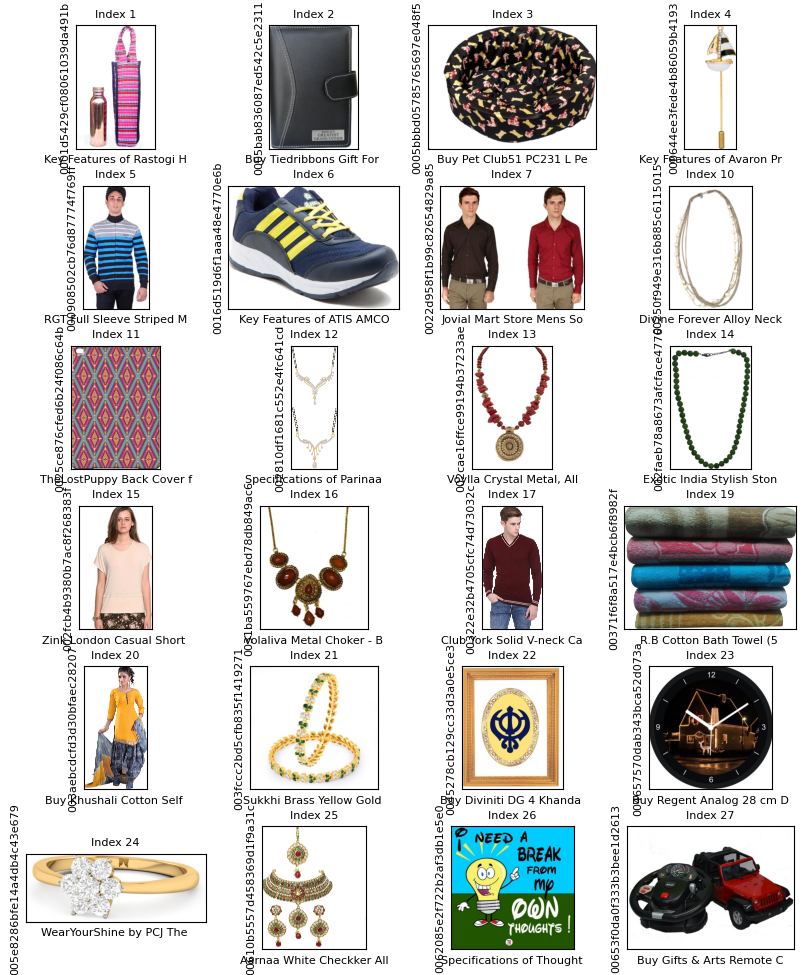

In [106]:
from io import BytesIO
import matplotlib.pyplot as plt
import math
import requests

# Calculate the number of rows and columns needed to display the images
num_cols = 4
#num_rows = math.ceil(len(df) / num_cols)
num_rows = 6
num_images = 0
num_images_max = num_cols * num_rows

# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for index, row in df.iterrows():
    if num_images > num_images_max - 1:
      continue
    #print("Processing Image:", num_images)

    id = row["uniq_id"]
    image_path = f"/content/pimproductimages/{id}.jpg"
    try:
      image = np.array(plt.imread(image_path))
    except Exception as error:
      print("Skipping:", image_path, "Message:", error)
      continue
    row_description = row["description"]

    # Calculate the row and column index for the current image
    row_idx = num_images // num_cols
    col_idx = num_images % num_cols


    # Display the image in the current subplot
    axs[row_idx, col_idx].imshow(image, cmap="gray")
    #axs[row_idx,col_idx].set_url(ObjectImage)

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Index {index+1}",fontsize=8)  # noqa
    axs[row_idx, col_idx].set_xlabel(f"{row_description[:25]}",fontsize=8)
    axs[row_idx, col_idx].set_ylabel(f"{id[:25]}",fontsize=8)

    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])
    num_images = num_images + 1

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

## Test Case 1: Can Vector Search find products similar to a T Shirt?

### Generate text and image embedding for a T Shirt image:

Token size: 31 Length: 141
Embedding Time:  4.6067516803741455
Gemini Description:  The image shows a young man wearing a blue and white striped shirt
and black jeans. He has one hand in his hair and the other in his
pocket.
Original Description: Men's Striped T Shirt stylish and sleek - great for the party


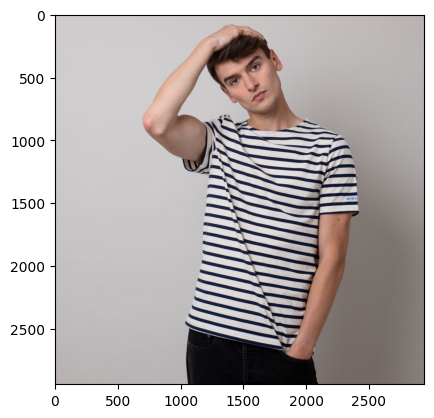

In [107]:
Description = "Men's Striped T Shirt stylish and sleek - great for the party"
IMAGE_URL = "https://bretonshirt.com/cdn/shop/files/DSC_1321.jpg?v=1705928758"

urllib.request.urlretrieve(IMAGE_URL, "my_file.jpg")
image_path = "/content/my_file.jpg"

gems = GeminiResponse(image_path)
augmentedDescription = Description + gems
emb = embed(text=Description,image_path=image_path, project=PROJECT)

# Read the image and display
image = np.array(plt.imread(image_path))

print("Gemini Description:", textwrap.fill(gems))
print("Original Description:", textwrap.fill(Description))

#Display image
plt.imshow(image)

### Generate Nearest Neighbors for Test Case 1

In [108]:
response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=[emb.text_embedding,emb.image_embedding],
    num_neighbors=NUM_NEIGHBORS,
)

response

[[MatchNeighbor(id='000908502cb76d87774f769ff431606d_T', distance=0.516579270362854),
  MatchNeighbor(id='0141a1c365876f10870653e3b4426465_T', distance=0.5550279021263123),
  MatchNeighbor(id='0072836d8c9195a016594f048b1f2350_T', distance=0.5579410195350647),
  MatchNeighbor(id='002810df1681c552e4fc641cd1486e7f_T', distance=0.617711067199707),
  MatchNeighbor(id='0062085e2f722b2af3db1e5e0b934d9f_T', distance=0.6182137131690979),
  MatchNeighbor(id='009245c1f782156562d519de64101cfe_T', distance=0.625764012336731),
  MatchNeighbor(id='00f20f4dfedbc2a62547884e81da367b_T', distance=0.6279392242431641)],
 [MatchNeighbor(id='00f713ac460e7e07e8aba53ee9ef3b47_I', distance=0.4230997562408447),
  MatchNeighbor(id='000908502cb76d87774f769ff431606d_I', distance=0.5502800345420837),
  MatchNeighbor(id='00322e32b4705cfc74d73032c39a44ab_I', distance=0.5660237073898315),
  MatchNeighbor(id='002fcb4b9380b7ac8f268383fc6a47c3_I', distance=0.5715839862823486),
  MatchNeighbor(id='00e78be6c8c6451c233068f01

### Visualize Nearest Neighbors for Test Case 1

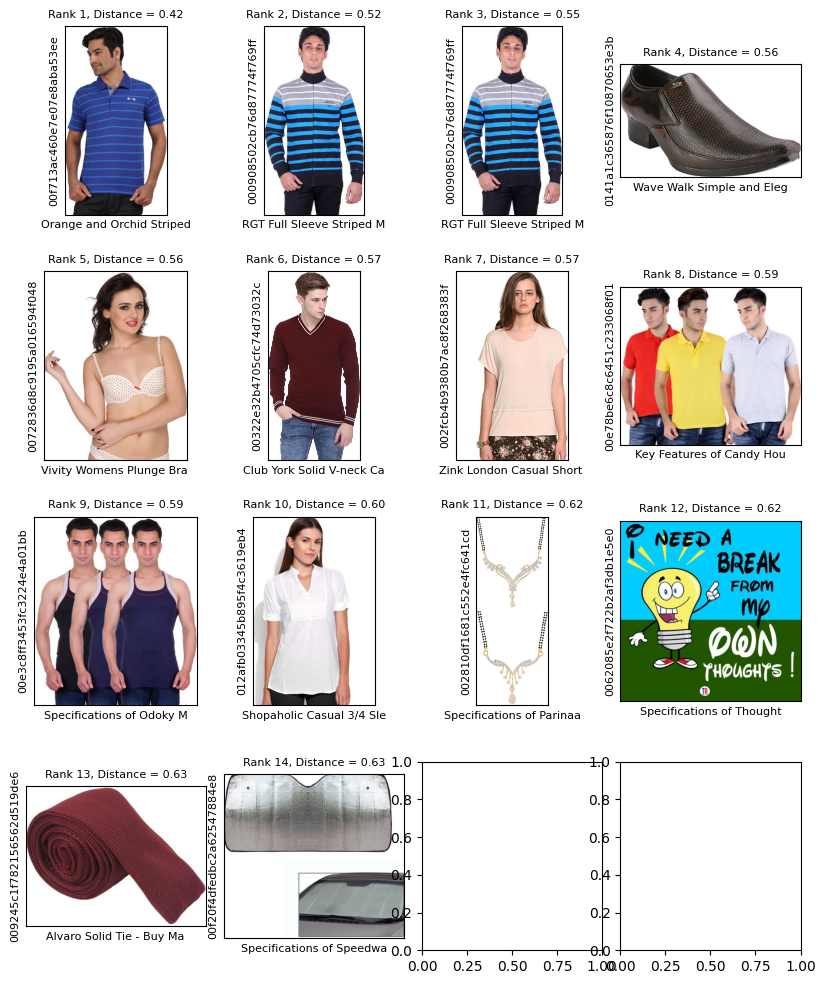

In [109]:
def left(s, amount):
    return s[:amount]

neighbors = []

for neighborlist in response:
  for neighbor in neighborlist:
    neighbors.append(neighbor)

# Sort images and scores by descending order of scores and select the top max_images
#sorted_data = sorted(response.nearest_neighbors[0].neighbors, key=lambda x: x.distance, reverse=True)
sorted_data = sorted(neighbors, key=lambda x: x.distance, reverse=False)


# Calculate the number of rows and columns needed to display the images
num_cols = 4
num_rows = math.ceil(len(sorted_data) / num_cols)


# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, datalist in enumerate(sorted_data):
    #id = left(datalist.datapoint.datapoint_id,len(datalist.datapoint.datapoint_id)-2)
    id = left(datalist.id,len(datalist.id)-2)
    image_path = ast.literal_eval(df["image"][df["uniq_id"]== id].iloc[0])[0]
    Dist = datalist.distance
    neighbor_description = df["description"][df["uniq_id"]== id].iloc[0]

    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

    image_path = f"/content/pimproductimages/{id}.jpg"

    # Read the image and display
    try:
      image = np.array(plt.imread(image_path))
    except Exception as error:
      print("Skipping:", image_path, "Message:", error)
      continue

    # Display the image in the current subplot
    axs[row_idx, col_idx].imshow(image, cmap="gray")

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Rank {i+1}, Distance = {Dist:.2f}", fontsize=8)  # noqa
    #axs[row_idx, col_idx].annotate(f"{neighbor_description[:10]}", (1, 1), fontsize=10)
    axs[row_idx, col_idx].set_xlabel(f"{neighbor_description[:25]}", fontsize=8)
    axs[row_idx, col_idx].set_ylabel(f"{id[:25]}", fontsize=8)


    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()


## Test Case 2: Can Vector Search find products similar to a pendant?

### Generate Text & Image embeddings for a pendant

Token size: 29 Length: 142
Embedding Time:  1.3206262588500977
Gemini Description:  This is a pendant necklace with a pear-shaped garnet gemstone in a
rose gold setting. The gemstone is dark red in color and has a high
shine.
Original Description: Angara Pendant


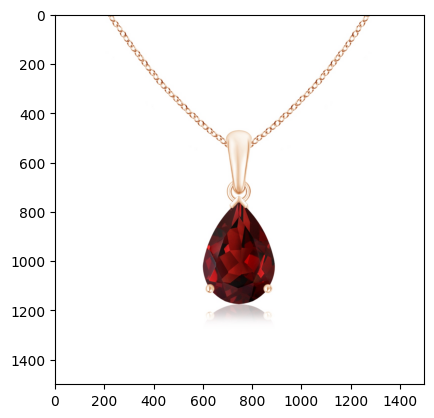

In [110]:
Description = "Angara Pendant"
IMAGE_URL="https://assets.angara.com/pendant/sp0448g_n/10x7mm-aaaa-garnet-rose-gold-pendant.jpg?width=1920&quality=95"

urllib.request.urlretrieve(IMAGE_URL, "my_file.jpg")
image_path = "/content/my_file.jpg"

gems = GeminiResponse(image_path)
augmentedDescription = Description + gems
emb = embed(text=Description,image_path=image_path, project=PROJECT)

# Read the image and display
image = np.array(plt.imread(image_path))

print("Gemini Description:", textwrap.fill(gems))
print("Original Description:", textwrap.fill(Description))

#Display image
plt.imshow(image)


### Generate Nearest Neighbors for Test Case 2

In [111]:
response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=[emb.text_embedding,emb.image_embedding],
    num_neighbors=NUM_NEIGHBORS,
)

response

[[MatchNeighbor(id='002810df1681c552e4fc641cd1486e7f_T', distance=0.5805063247680664),
  MatchNeighbor(id='00bf204f591bea9ef88730ded8a155e5_T', distance=0.6151996850967407),
  MatchNeighbor(id='00b35cdacb0bf4230cb8372774bc0e8c_T', distance=0.6264461278915405),
  MatchNeighbor(id='01096382ec89a0e7a93d29dbf731882c_T', distance=0.644730806350708),
  MatchNeighbor(id='00f20f4dfedbc2a62547884e81da367b_T', distance=0.6447328925132751),
  MatchNeighbor(id='0100beb24bfc0cc4ab13177e63088c06_T', distance=0.6568433046340942),
  MatchNeighbor(id='005e8286bfe14a4db4c43e6794be20c1_T', distance=0.6570395231246948)],
 [MatchNeighbor(id='0031ba559767ebd78db849ac6df06257_I', distance=0.5436240434646606),
  MatchNeighbor(id='002cae16ffce99194b37233ae182f62f_I', distance=0.5862593650817871),
  MatchNeighbor(id='00610b5557d458369d1f9a31cf81850f_I', distance=0.5870338082313538),
  MatchNeighbor(id='003fccc2bd5cfb835f14192710eb4990_I', distance=0.6116690039634705),
  MatchNeighbor(id='002810df1681c552e4fc641

### Visualize Nearest Neighbors for Test Case 2

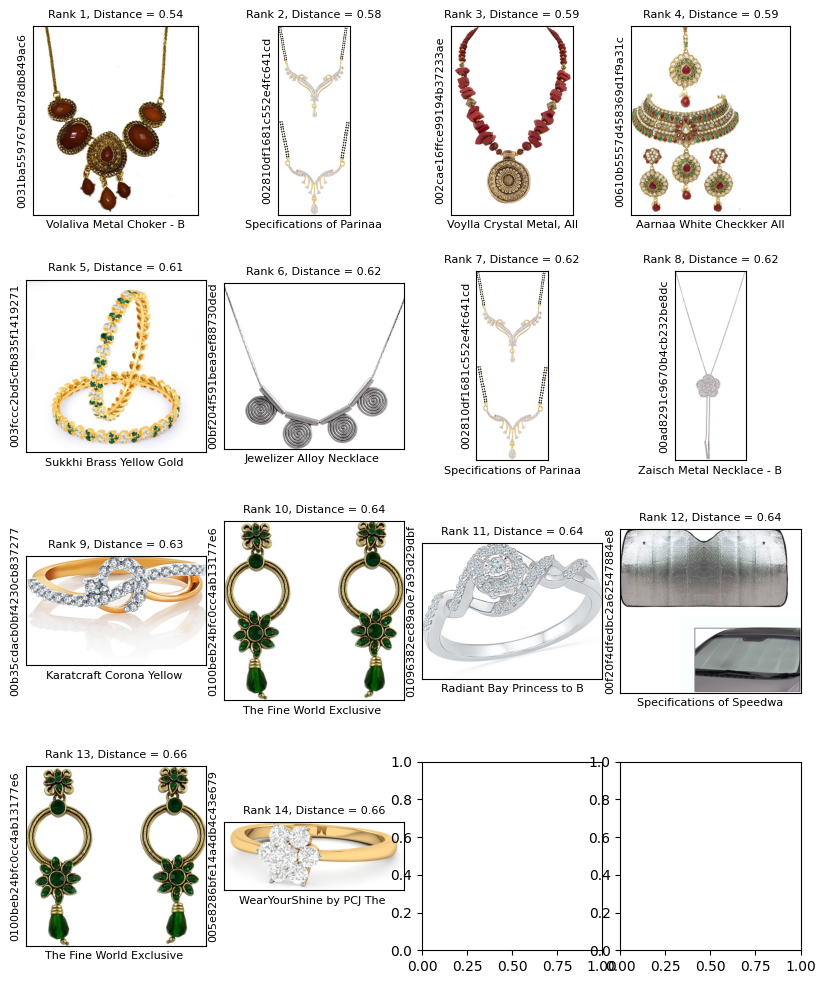

In [112]:
def left(s, amount):
    return s[:amount]

neighbors = []

for neighborlist in response:
  for neighbor in neighborlist:
    neighbors.append(neighbor)

# Sort images and scores by descending order of scores and select the top max_images
#sorted_data = sorted(response.nearest_neighbors[0].neighbors, key=lambda x: x.distance, reverse=True)
sorted_data = sorted(neighbors, key=lambda x: x.distance, reverse=False)


# Calculate the number of rows and columns needed to display the images
num_cols = 4
num_rows = math.ceil(len(sorted_data) / num_cols)


# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, datalist in enumerate(sorted_data):
    #id = left(datalist.datapoint.datapoint_id,len(datalist.datapoint.datapoint_id)-2)
    id = left(datalist.id,len(datalist.id)-2)
    image_path = ast.literal_eval(df["image"][df["uniq_id"]== id].iloc[0])[0]
    Dist = datalist.distance
    neighbor_description = df["description"][df["uniq_id"]== id].iloc[0]

    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

    image_path = f"/content/pimproductimages/{id}.jpg"

    # Read the image and display
    try:
      image = np.array(plt.imread(image_path))
    except Exception as error:
      print("Skipping:", image_path, "Message:", error)
      continue

    # Display the image in the current subplot
    axs[row_idx, col_idx].imshow(image, cmap="gray")

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Rank {i+1}, Distance = {Dist:.2f}", fontsize=8)  # noqa
    #axs[row_idx, col_idx].annotate(f"{neighbor_description[:10]}", (1, 1), fontsize=10)
    axs[row_idx, col_idx].set_xlabel(f"{neighbor_description[:25]}", fontsize=8)
    axs[row_idx, col_idx].set_ylabel(f"{id[:25]}", fontsize=8)


    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

# Summary of Results

In this notebook, we were able to build a vector store using Vertex Matching Engine for a public repo of product images (Kaggle), Generate embeddings for 2 test cases and retrieve similar product images & descriptions for those 2 test cases.